## Времянные ряды 4

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, SelectPercentile, SelectFromModel
import os
warnings.simplefilter(action='ignore', category=FutureWarning)


__1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.__

In [2]:
data = pd.read_csv('../lesson4/my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data_w = data.resample('W').mean()
data_w.drop(columns=['year', 'hour','dayofweek','dayofmonth', 'dayofyear',
                     'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)

__2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.__

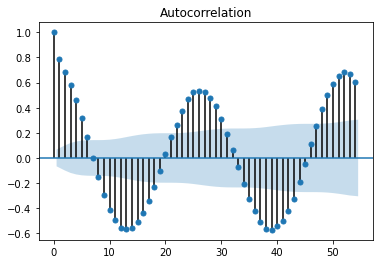

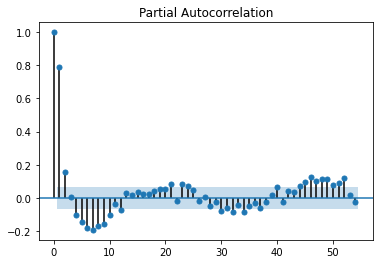

In [3]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=54)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=54)
plt.show()

In [4]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0.0
data_w['diff1'].values[1:] = first_diff

first_diff_w = first_diff/data_w.iloc[1:,0].values
data_w['diff1_w'] = 0.0
data_w['diff1_w'].values[1:] = first_diff_w

first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0.0
data_w['diff1_l'].values[1:] = first_diff_l

first_diff_s =np.sqrt(data_w.iloc[1:,0].values) 
data_w['diff1_s'] = 0.0
data_w['diff1_s'].values[1:] = first_diff_s


In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)
data_w['exp_0_5'] = exponential_smoothing(data_w['PJME_MW'], 0.5)
data_w['exp_0_99'] = exponential_smoothing(data_w['PJME_MW'], 0.99)

In [6]:
data_w.head(5)

,PJME_MW,month,quarter,weekofyear,diff1,diff1_w,diff1_l,diff1_s,exp_0_05,exp_0_5,exp_0_99
Date,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839
2002-01-13,31487.386905,1.000000,1.0,2.0,-904.773926,-0.028734,10.357342,177.446857,32346.922142,31939.773872,31496.434644
2002-01-20,31452.880952,1.000000,1.0,3.0,-34.505951,-0.001097,10.356246,177.349601,32302.220083,31696.327412,31453.316489
2002-01-27,30141.529762,1.000000,1.0,4.0,-1311.351196,-0.043506,10.313659,173.613161,32194.185567,30918.928587,30154.647629
2002-02-03,29196.488095,1.428571,1.0,5.0,-945.041687,-0.032368,10.281804,170.869799,32044.300693,30057.708341,29206.069691


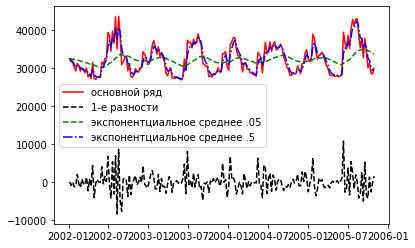

In [7]:
N100=200
idx = data_w.index[:N100]
plt.plot(idx,data_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(idx,data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(idx,data_w['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее .05')
plt.plot(idx,data_w['exp_0_5'][:N100],'-.b',label ='экспонентциальное среднее .5')
plt.legend()
plt.show()


In [8]:
p = 52
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]
    
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]    

In [9]:
scl_target=StandardScaler() 
h=4
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(810, 1)

In [10]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(810, 115)

In [11]:
#X[:p,14] не понимаю откуда взлось число 14? 

In [12]:
f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)

sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())

sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())

gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)


In [13]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [13 14 15 16 17]
Номера признаков лучших признаков по процентной форме:  [13 14 15 16 17 27 28 29 41 53 54 55]
Номера признаков для выбора по модели :  [14 15 29 40 41]


In [14]:
list(set(list_param_k).union(list_param_p).union(list_param_m))

[40, 41, 13, 14, 15, 16, 17, 53, 54, 55, 27, 28, 29]

In [15]:
list_par= list(set(list_param_k).union(list_param_p).union(list_param_m))
data_w.columns[list_par]

Index(['t23', 't22', 't50', 't49', 't48', 't47', 't46', 't10', 't9', 't8',
       't36', 't35', 't34'],
      dtype='object')

In [16]:
X_new = X[:,list_par]

In [17]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

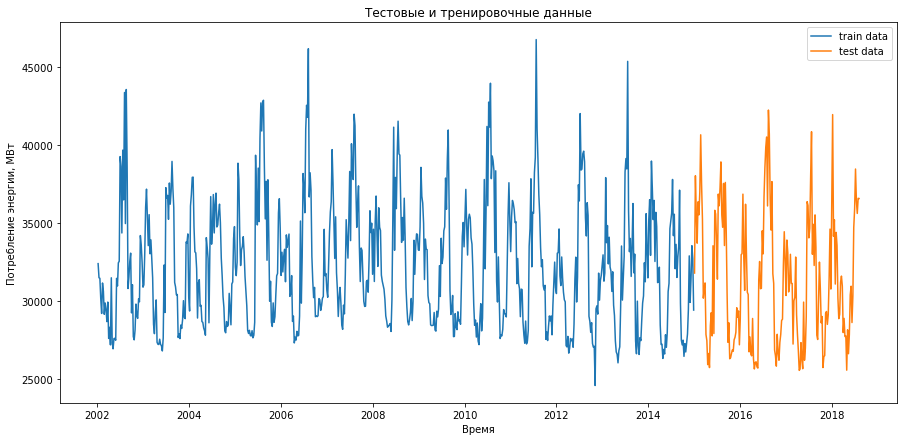

In [18]:
train, test = split_data( data_w, '01-01-2015')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [19]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test4 =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [20]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [21]:
param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

In [22]:
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)


Model with rank: 1
Mean validation score: 0.585 (std: 0.060)
Parameters: {'n_estimators': 100, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.577 (std: 0.075)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.559 (std: 0.075)
Parameters: {'n_estimators': 100, 'max_depth': 4}



In [23]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=100)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test4)


In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test4)

print(f'predict: {y_test_pred_g[3]}\ntrue: \t{y_train[3]}')

predict: 1.3575390769720448
true: 	0.23086436590458304


__3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.__

In [26]:
scl_target=StandardScaler() 
h=1
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(813, 1)

In [27]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(813, 115)

In [28]:
f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)

sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())

sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())

gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)

In [29]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0  6  7  9 10]
Номера признаков лучших признаков по процентной форме:  [ 0  6  7  9 10 11 12 13 14 25 26 62]
Номера признаков для выбора по модели :  [ 0  6  7 10 12]


In [30]:
list_par= list(set(list_param_k).union(list_param_p).union(list_param_m))
data_w.columns[list_par]

Index(['PJME_MW', 'diff1_l', 'diff1_s', 'exp_0_5', 'exp_0_99', 't52', 't51',
       't50', 't49', 't38', 't37', 't1'],
      dtype='object')

In [31]:
X_new = X[:,list_par]

In [32]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test1 =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [33]:
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.692 (std: 0.055)
Parameters: {'n_estimators': 100, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.678 (std: 0.063)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.670 (std: 0.067)
Parameters: {'n_estimators': 300, 'max_depth': 1}



In [34]:
model_g_best = GradientBoostingRegressor(max_depth=1,  n_estimators=100)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test1)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print(f'predict: {y_test_pred_g[0]}\ntrue: \t{y_train[0]}')

predict: 0.09476365291663329
true: 	0.22846243952736361


__4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.__

In [35]:
data_w.columns[list_par]

Index(['PJME_MW', 'diff1_l', 'diff1_s', 'exp_0_5', 'exp_0_99', 't52', 't51',
       't50', 't49', 't38', 't37', 't1'],
      dtype='object')

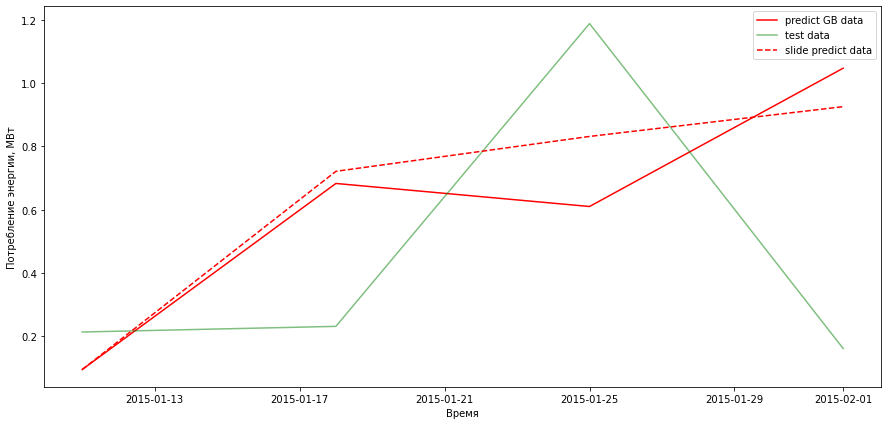

In [36]:
warnings.simplefilter(action='ignore', category=RuntimeWarning)
X_test_100 = X_test1.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 100
for i in range(N10):
    y_test_100[i] = model_g_best.predict(np.nan_to_num(X_test_100[i,:].reshape((1,-1))))
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = y_test_100[i]
    X_test_100[i+1,1] = np.array(X_test_100[1:,0] - X_test_100[:-1,0])[i+1]
    X_test_100[i+1,2] = np.sqrt(X_test_100[1:,0])[i+1]
    X_test_100[i+1,3] = exponential_smoothing(X_test_100[:,3], 0.5)[i+1]
    X_test_100[i+1,4] = exponential_smoothing(X_test_100[:,4], 0.99)[i+1]
  
    X_test_100[i+1,5] = y_test_100[-p+52]
    X_test_100[i+1,6] = y_test_100[-p+51]
    X_test_100[i+1,7] = y_test_100[-p+50]
    X_test_100[i+1,8] = y_test_100[-p+49]
    X_test_100[i+1,9] = y_test_100[-p+38]
    X_test_100[i+1,10] = y_test_100[-p+37]
    X_test_100[i+1,11] = y_test_100[-p+1]
    if i>p:
        X_test_100[i+1,4] = np.mean(X_test_100[i+1-p:i+1,0]) 
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:4+1],y_test_pred_g[:4], 'r',label='predict GB data' )
plt.plot(test.index[1:4+1],y_test[:4], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:4+1],y_test_100[:4], '--r',label='slide predict data')

plt.legend()
plt.show()  

__5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)__

In [37]:
errs = []
for i in range(10):
    e = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[10*i:10*i +10]),y_pred = scl_target.inverse_transform( y_test_100[10*i:10*i +10]))
    print(e)
    errs.append(e)

10.305700971975673
22.832465666855423
7.213963115712516
11.876233483460744
16.098080360130815
12.542102289708126
26.558430177996605
16.283963246273615
12.980748357834287
27.6912331172229


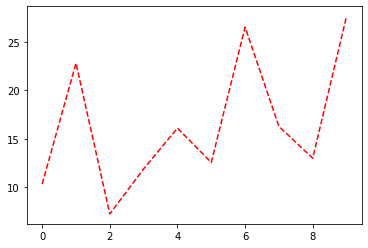

In [38]:
plt.plot(np.arange(10),errs, '--r')

__6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.__

График изменения ошибки имеет цикличность???
И кажется имеет тренд.
